In [91]:
# Prophet model for time series forecast
import prophet
import pyspark
import darts

# Data processing
import pandas as pd
import numpy as np
import csv

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Multi-processing
from multiprocessing import Pool, cpu_count

# Spark
from pyspark.sql.types import *
from pyspark.sql.functions import pandas_udf, PandasUDFType
from prophet import Prophet

# Process bar
from tqdm import tqdm

# Tracking time
from time import time

#hmm needed? 
import torch
import torch.nn as nn
import torch.optim as optim
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

#darts
# transformers and preprocessing
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import TransformerModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf


In [108]:
#Data preparation
data = pd.read_csv('life_expectancy.csv')


#Make datetime
data['Year'] = pd.to_datetime(data['Year'])

#Exclude entries that are not countries
exclude = ['Africa', 'Asia', 'Europe', 'High-income countries', 'Land-locked Developing Countries (LLDC)', 'Latin America and the Caribbean','Least developed countries','Less developed regions','Less developed regions, excluding China','Less developed regions, excluding least developed countries', 'Low-income countries','Lower-middle-income countries','More developed regions','Northern America','Oceania','Small Island Developing States (SIDS)','Upper-middle-income countries','World']

# Subset the DataFrame based on the countries of interest
data_countries = data.loc[~data['Country'].isin(exclude)]

# Rename Life expectancy column
data_countries.rename(columns={'Life expectancy at birth (historical)': 'LE'}, inplace=True)


#Transform dataset into TimeSeries
dataset_ts = TimeSeries.from_group_dataframe(df=data_countries, 
                                             group_cols=['Country'],
                                             time_col='Year', 
                                             value_cols='LE')


#Scale the target values
from darts.dataprocessing.transformers import Scaler

scaler = Scaler()

#Scale the full dataset
dataset_ts_scaled = scaler.fit_transform(dataset_ts)

#Split in train, val, and test

#We set aside 75% for training - 54 years (1950-2004)
#And set asise 25% for testing - 17 years (2005-2021)

first_test_date = pd.Timestamp('2005-01-01')
train_dataset_ts, test_dataset_ts = [], []

for single_ts in tqdm(dataset_ts_scaled):
    # split into train and test tests
    single_train_ts, single_test_ts = single_ts.split_before(first_test_date)
    train_dataset_ts.append(single_train_ts)
    test_dataset_ts.append(single_test_ts)


/tmp/ipykernel_830/4230407566.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_countries.rename(columns={'Life expectancy at birth (historical)': 'LE'}, inplace=True)
/tmp/ipykernel_830/4230407566.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for single_ts in tqdm(dataset_ts_scaled):


  0%|          | 0/238 [00:00<?, ?it/s]

In [109]:
#Insoect columns
print(data_countries.columns)

Index(['Country', 'Year', 'LE'], dtype='object')


In [111]:
print(data_countries.columns)

Index(['Country', 'Year', 'LE'], dtype='object')


<AxesSubplot:xlabel='Year', ylabel='LE'>

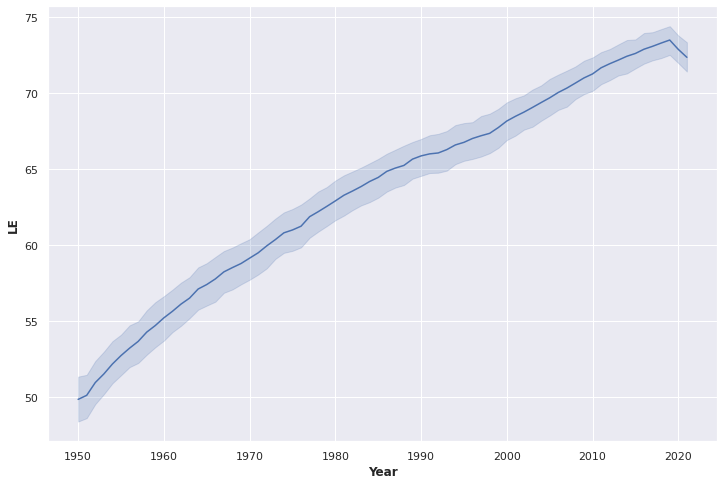

In [113]:
sns.set(rc={'figure.figsize':(12,8)})
sns.lineplot(x=data_countries['Year'], y=data_countries['LE'])

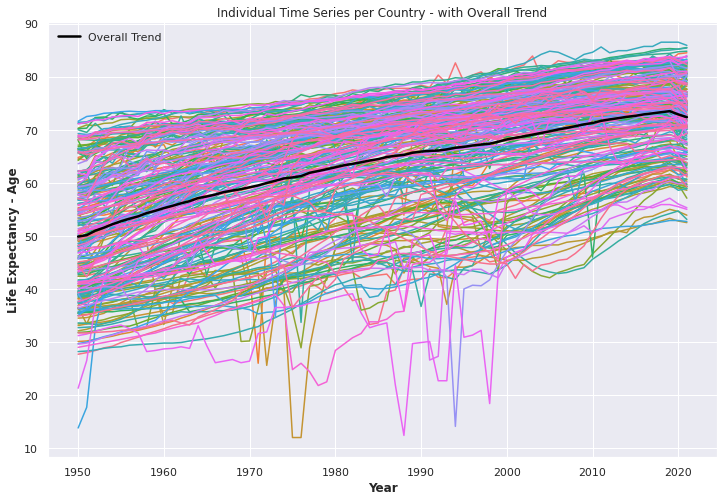

In [114]:
# Set the figure size
sns.set(rc={'figure.figsize':(12,8)})

# Plotting individual time series per country with overlapping lines and no legend
sns.lineplot(x='Year', y='LE', hue='Country', data=data_countries, legend=False)

# Calculate the overall trend (e.g., average)
overall_trend = data_countries.groupby('Year')['LE'].mean()

# Plot the overall trend line
plt.plot(overall_trend.index, overall_trend, color='black', linestyle='-', lw=2.5, label='Overall Trend')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Life Expectancy - Age')
plt.title('Individual Time Series per Country - with Overall Trend')
plt.grid(True)
plt.legend()
plt.show()


In [115]:
print(type(dataset_ts_scaled))

<class 'list'>


In [81]:
data_countries.info

<bound method DataFrame.info of            Country       Year    LE
0      Afghanistan 1950-01-01  27.7
1      Afghanistan 1951-01-01  28.0
2      Afghanistan 1952-01-01  28.4
3      Afghanistan 1953-01-01  28.9
4      Afghanistan 1954-01-01  29.2
...            ...        ...   ...
18427     Zimbabwe 2017-01-01  60.7
18428     Zimbabwe 2018-01-01  61.4
18429     Zimbabwe 2019-01-01  61.3
18430     Zimbabwe 2020-01-01  61.1
18431     Zimbabwe 2021-01-01  59.3

[17136 rows x 3 columns]>